# Predicting Gentrification
*A study into planning application features that can help to signal early warnings of gentrification*
</br></br></br></br>
`Notebook 3`</br>
Author: Mariia Shapovalova</br>
Date: April, 2023

---
## Table of Contents
Notebook 3: Merge+EDA+Model_prep
- 0.0 Introduction
- 1.0 Merge Permits and Income Datasets
- 2.0 OHE Sample Workflow
- 3.0 Grouping by Year and Census Tract
- 4.0 2 Sample T-Test
- 5.0 Multicollinearity
- 6.0 NLP Analysis


---
<center><h2 id="identifier_0">INTRODUCTION</h2><center>

This notebook:
* Merges the two datasets: permits and income data
* Separates the dataset into **test** and **remainder** sets
* Develops workflows (such as overwriting sklearn classes) to be later applied at the modelling stage and writing functions that can be then converted into Column Transformers
  * Note: some functions and classes from this notebook are not then directly used in the modelling noteboook, but nevetheless offer an explanation of how the final modelling workflow was established
* Conducts Further EDA 
* Fits intial models

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from functions import *

from sklearn.feature_extraction.text import TfidfVectorizer
import string

# import the nltk stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tag import pos_tag 
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\44742\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


***

### LOAD DATA

In [3]:
#load cleaned income data
income_df=pd.read_csv('../data/clean/income_cleaned.csv',index_col=0)

#load cleaned combined metric
combined_df=pd.read_csv('../data/clean/df_combined_metric.csv',index_col=0)

#load cleaned planning data
permit_df=pd.read_csv('../data/clean/permits_cleaned.csv',index_col=0)

* After cleaning up the columns some duplciate row appeared, let's drop them

In [4]:
#Expand the cell to check permit_df 
overview(permit_df)

The dataframe shape is (730511, 16)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
PERMIT_TYPE,object,0,0.0,RENOVATION/ALTERATION,ELECTRIC WIRING,ELECTRIC WIRING
REVIEW_TYPE,object,0,0.0,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT WEB
WORK_DESCRIPTION,object,0,0.0,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,REPAIR SERVICE,INSTAL PUBLIK METER AND PANEL
CONTACT_1_TYPE,object,0,0.0,OWNER AS GENERAL CONTRACTOR,CONTRACTOR-ELECTRICAL,CONTRACTOR-ELECTRICAL
CONTACT_1_CITY,object,0,0.0,CHICAGO,CHICAGO_SUBURBS,OTHER
CONTACT_1_STATE,object,0,0.0,IL,OTHER,IL
CENSUS_TRACT,int64,0,0.0,220702,530503,150502
LOG_PROCESSING_TIME,float64,0,0.0,4.394449,-23.025851,-23.025851
LOG_BUILDING_FEE_PAID,float64,0,0.0,4.828314,4.317488,3.912023


In [5]:
#Expand the cell to check income_df 
overview (income_df)

The dataframe shape is (725, 14)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
Census_Tract,float64,0,0.0,10100.00,844700.00,161000.00
Household_Count,float64,0,0.0,2224.50,650.50,799.00
Mean_Income_2010,float64,0,0.0,51153.00,37440.50,87157.00
Mean_Income_2011,float64,0,0.0,46073.00,36450.50,85856.00
Mean_Income_2012,float64,0,0.0,45816.00,33392.00,81483.00
Mean_Income_2013,float64,0,0.0,46395.33,35530.83,83381.67
Mean_Income_2014,float64,0,0.0,46010.33,34517.67,80339.00
Mean_Income_2015,float64,0,0.0,46617.67,35627.00,77398.33
Mean_Income_2016,float64,0,0.0,46764.00,35681.50,79522.67


In [6]:
#Expand the cell to check income_df 
overview (combined_df)

The dataframe shape is (725, 14)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
Census_Tract,float64,0,0.0,10100.000000,844700.000000,30604.000000
Household_Count,float64,0,0.0,2224.500000,650.500000,1977.000000
Combined_metric_2010,float64,0,0.0,-0.163154,-0.810643,0.287431
Combined_metric_2011,float64,0,0.0,-0.361371,-0.874801,0.524711
Combined_metric_2012,float64,0,0.0,-0.392177,-1.031619,0.373282
Combined_metric_2013,float64,0,0.0,-0.267212,-0.959963,0.264990
Combined_metric_2014,float64,0,0.0,-0.224836,-0.922377,0.241168
Combined_metric_2015,float64,0,0.0,-0.214409,-0.881091,0.181814
Combined_metric_2016,float64,0,0.0,-0.328704,-0.965953,0.090092


---
**<center><h2>MERGE<center><h2>**

* Merge **Permit_df** and **Income_df** on `Census Tract`

In [7]:
#Merge on Census_Tract
df_merged=pd.merge(permit_df,income_df,how='inner',left_on='CENSUS_TRACT', right_on='Census_Tract').drop(columns='CENSUS_TRACT')

In [8]:
#Merge on Census_Tract COMBINED METRIC ITERATION
df_merged_2=pd.merge(permit_df,combined_df,how='inner',left_on='CENSUS_TRACT', right_on='Census_Tract').drop(columns='CENSUS_TRACT')

In [9]:
#Expand the cell to check merged dataframe - df_merged
overview (df_merged_2)

The dataframe shape is (724869, 29)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
PERMIT_TYPE,object,0,0.0,RENOVATION/ALTERATION,ELECTRIC WIRING,DROP
REVIEW_TYPE,object,0,0.0,STANDARD PLAN REVIEW,EASY PERMIT WEB,DEMOLITION PERMIT
WORK_DESCRIPTION,object,0,0.0,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,INSTALLATION OF (1) 30 AMP DUAL POLE BREAKER A...,EMERGENCY WRECK AND REMOVE A 1 STORY MASONRY B...
CONTACT_1_TYPE,object,0,0.0,OWNER AS GENERAL CONTRACTOR,CONTRACTOR-ELECTRICAL,CONTRACTOR-WRECKING
CONTACT_1_CITY,object,0,0.0,CHICAGO,CHICAGO,CHICAGO
CONTACT_1_STATE,object,0,0.0,IL,IL,IL
LOG_PROCESSING_TIME,float64,0,0.0,4.394449,1.791759,4.406719
LOG_BUILDING_FEE_PAID,float64,0,0.0,4.828314,3.688879,6.214608
LOG_ZONING_FEE_PAID,float64,0,0.0,4.317488,-23.025851,-23.025851


In [10]:
df_merged.to_csv('../data/clean/merged_income_df')
df_merged_2.to_csv('../data/clean/merged_combined_df')

***
<center><h2>OHE<center><h2>

* ONE HOT ENCODING won't be applied to the dataset exported from this notebook because this would prevent from running cross validation correctly
* Instead, this section focuses on defining the workflow that can be later replicated in the modelling notebook
* Additionally, OHE is required to conduct futher EDA
* `mention data leakage`

* First Step in the modelling preparation is to conduct One Hot Encoding for the categorical columns
* Convert any relevant qualitative columns into quantitative columns
  * Cleaning process was done with ohe in mind, hence all qualitative columns, apart from Work Description, should  be ready to be one hot encoded

* Consider the number of unique categories to determine the appropriatness of OneHotEncoding

In [11]:
#df_merged=df_merged_2.copy()

In [12]:
df_cat=df_merged.select_dtypes("object")
df_cat.nunique()

PERMIT_TYPE              7
REVIEW_TYPE             11
WORK_DESCRIPTION    559400
CONTACT_1_TYPE          25
CONTACT_1_CITY           7
CONTACT_1_STATE          4
Class_Names              4
dtype: int64

* All categorical columns, apart from 'WORK_DESCRIPTION' can be one hot encoded

In [13]:
#select all categorical columns apart from the 'WORK_DESCRIPTION' column
ohe_col=df_cat.drop(columns='WORK_DESCRIPTION').select_dtypes(include=['object']).columns
ohe_col

Index(['PERMIT_TYPE', 'REVIEW_TYPE', 'CONTACT_1_TYPE', 'CONTACT_1_CITY',
       'CONTACT_1_STATE', 'Class_Names'],
      dtype='object')

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomOneHotEncoder_CT(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.encoder = OneHotEncoder(**kwargs)
        self.ohe_col=None
    
    def fit(self, X, y=None):

        if 'WORK_DESCRIPTION' in X.columns:
            ohe_col=X.drop(columns='WORK_DESCRIPTION').select_dtypes(include=['object']).columns
        else: 
            ohe_col=X.select_dtypes(include=['object']).columns


        self.encoder.fit(X[ohe_col])
        self.ohe_col=ohe_col
        return self
    
    def transform(self, X):
        transformed_data = self.encoder.transform(X[self.ohe_col])
        column_names = self.encoder.get_feature_names_out()
        df = pd.DataFrame(transformed_data.toarray(), columns=column_names)
        df=pd.concat([X,df],axis=1)
        df = df.drop(columns=self.ohe_col)
        return df

***
NOTE "Previous steps taken"

* Note: initally a similar result was achieved using a function applying one hot encoding. 
* However, ohe should only be applied to the trianing set, hence fit and transform methods had to be separated
* To view the intial function, please, expand the cell below

In [15]:
def ohe_cat(df,col_li):
    '''
    Use:
        Apply OHE for the specified columns only and returns a new full dataframe
    
    Inputs:
        df (pandas.DataFrame): Input DataFrame
        col_li(list): List of column names to apply OHE
    
    Returns:
        df_result(Pandas DataFrame): Result DataFrame with OHE applied to specified columns'''

    #copy dataframe 
    df_result=df.copy()

    # Iterate through each column in the input list
    for col in col_li:

        #Instantiate the encoder
        enc = OneHotEncoder(sparse=False)

        #Encode and convert it into a new DataFrame with column names including the original column name
        df_temp=pd.DataFrame(enc.fit_transform(df[[col]]),columns=[col+'_'+i for i in enc.categories_[0]])

        # Concatenate the encoded df with the existing DataFrame
        df_result=pd.concat([df_result,df_temp],axis=1)

    # Drop the original categorical columns from the result DataFrame
    df_result=df_result.drop(columns=col_li)

    return df_result

* Additionally, it was also attempted overwrite OneHotEncoder class`and create a custom OneHotEncoder
* It worked but using a custom column transformer appeared more appropriate than creating a custom OneHotEncoder because no functionality of the actual OneHotEncoding was being modified
* To view the intiial custom one hot encdoer class, please expand the cell below

In [16]:
class CustomOneHotEncoder(OneHotEncoder):
    
    # Override the fit method to fit only the specified columns and return self
    def fit(self, X, col_li, y=None):
        '''
        Inputs:
            X(DataFrame) : Input DataFrame
            col_li(list) : List of columns to apply one hot encoding to
        Output:
            fitted self
        '''

        #super() is a built-in function to call the methods of the base class.
        super().fit(X[col_li])
        return self
        
    # Override the transform method to transform only the specified columns and return a DataFrame
    def transform(self, X, col_li):
        #
        transformed_data = super().transform(X[col_li])
        columns = self.get_feature_names_out()
        df = pd.DataFrame(transformed_data.toarray(), columns=columns)
        df = pd.concat([X.drop(col_li, axis=1), df], axis=1)
        return df

#TEST
'''
my_ohe = CustomOneHotEncoder()
df_rem_ohe = my_ohe.fit(df_rem, ohe_col)
df_rem_ohe = my_ohe.transform(df_rem, ohe_col)
df_rem_ohe.head()
'''

'\nmy_ohe = CustomOneHotEncoder()\ndf_rem_ohe = my_ohe.fit(df_rem, ohe_col)\ndf_rem_ohe = my_ohe.transform(df_rem, ohe_col)\ndf_rem_ohe.head()\n'

End of NOTE "Previous steps taken"

***

In [17]:
# Create an instance of the CustomOneHotEncoder class
encode_df=CustomOneHotEncoder_CT()

# Fit the encoder to the specified columns (ohe_col) in df_rem 
encode_df.fit(df_merged)

# Transform to get a one-hot encoded version of df_rem
df_model=encode_df.transform(df_merged)

df_model.head()

,WORK_DESCRIPTION,LOG_PROCESSING_TIME,LOG_BUILDING_FEE_PAID,LOG_ZONING_FEE_PAID,LOG_OTHER_FEE_PAID,LOG_SUBTOTAL_PAID,LOG_TOTAL_FEE,LOG_REPORTED_COST,YEAR,Census_Tract,...,CONTACT_1_CITY_OAK BROOK,CONTACT_1_CITY_OTHER,CONTACT_1_STATE_IL,CONTACT_1_STATE_NY,CONTACT_1_STATE_OTHER,CONTACT_1_STATE_TX,Class_Names_Not_Renovation,Class_Names_extension,Class_Names_office/alteration,Class_Names_repair/porch
0,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,4.394449,4.828314,4.317488,-23.025851,5.298317,5.298317,8.006368,2006,220702.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,REPLACE REAR OPEN WOOD PORCH WITH A NEW STEEL/...,3.583519,5.298317,3.912023,-23.025851,5.521461,5.521461,9.852194,2006,220702.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,DECONVERT 2ND FLOOR APARTMENT TO MAKE BUILDING...,-23.025851,4.442651,4.317488,-23.025851,5.075174,5.075174,7.600902,2006,220702.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,LOW VOLTAGE BURGLAR ALARM,2.197225,3.688879,-23.025851,-23.025851,3.688879,3.688879,5.991465,2006,220702.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,REPAIR EXISTNG TWO STORY WOOD FRAME PORCH PER ...,2.564949,4.442651,3.912023,-23.025851,4.905275,4.905275,8.342840,2006,220702.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


* Note, after one hot encoding there is still 1 qualitative column remaining - `Work_Description`
* `Work_Description` will be addressed in section `UDPATE`

###  `XXXXX`

***
<center><h3> Grouping by Cencus Tract and Year <center><h3>


**Dataframge Shape Template after the Grouping:**
| `Census Tract`| `Year` | Averaged Numerical X Feature 1 (for the given `ct` and `year`) | --- | Aggregated Qualitative Featute (for the given `ct` and `year`)| <span style="color:green">Mean Income in Year 2010 </span>| <span style="color:green">---</span>| <span style="color:green">Mean Income in Year 2021 </span>|
| --- | --- | --- | --- | --- | --- | --- |--- |
| 10100 | 2021 | XXX |XXX|XXX | XXX | XXX | XXX | 
| 10100 | 2020 | XXX |XXX |XXX |XXX | XXX | XXX | 
| 10100 | 2019 | XXX |XXX |XXX |XXX | XXX | XXX |
| --- | --- | --- |--- |--- |--- |--- |

The next step would be to merge information about each application into groups defined by census tract and year </br>
`improve`

Different approaches to quantitative and qualitative columns have to be taken when grouping the datapoints by year and census tract
* Quantitative columns (including one hot encoded columns) : take the mean
  * taking the mean is more accurate than aggregative quantitative columns because as seen in notebook 2, household counts for each census tract vary singnificantly
  * hence, it would be inaccurate
* Qualitative columns (descriptions only) : join all the descriptions together

In [18]:
def df_window_multi_type(df,year,t):

    '''
    Combines descriptions & numeric data
    Inputs:
    #df_description to only contain description columns
    '''
    #copy dataframe to avoid accidental overwriting
    df_temp=df.copy()

    if 'YEAR' not in df.columns:
        df_temp['YEAR']=df['ISSUE_DATE'].dt.year
        df_temp=df_temp.drop(columns='ISSUE_DATE')

    assert df_temp.index.is_monotonic_increasing, 'Check Indexing: Should be a simple arithmetic sequence'

    df_temp=df_temp.set_index(['Census_Tract','YEAR'])

    #to set 'YEAR' index as a column
    df_temp=df_temp.reset_index(level=1)

    #select relevant years
    #year+1 as the range end to esnure data for the current year is also included
    df_temp=df_temp[df_temp['YEAR'].isin(range(year-t,year+1))].drop(columns='YEAR')

    #instantiate the output dataframe
    df_result=pd.DataFrame()

    #select columns with distriptions
    obj_cols = df_temp.select_dtypes(include=['object']).columns
    num_cols = df_temp.select_dtypes(include=['number']).columns

    ### CAN ADD MORE FEATURES HERE ###

    #Taking averages for numeric columns
    for col in num_cols:
        df_result[col]=df_temp.groupby(level=0)[col].mean()

    #Concatenating qualitative columns
    for col in obj_cols:
        #need to keep in mind that some stings (descriptions) might be missing
        df_result[col]=df_temp.groupby(level=0)[col].apply(lambda x: ' '.join(str(i) for i in x))

    return df_result

In [19]:
#Example of the function use
#Making a prediction in 2015 based on training data for 2015 and 5 years before
df_window_multi_type(df_model,2015,5).head()

,LOG_PROCESSING_TIME,LOG_BUILDING_FEE_PAID,LOG_ZONING_FEE_PAID,LOG_OTHER_FEE_PAID,LOG_SUBTOTAL_PAID,LOG_TOTAL_FEE,LOG_REPORTED_COST,Household_Count,Mean_Income_2010,Mean_Income_2011,...,CONTACT_1_CITY_OTHER,CONTACT_1_STATE_IL,CONTACT_1_STATE_NY,CONTACT_1_STATE_OTHER,CONTACT_1_STATE_TX,Class_Names_Not_Renovation,Class_Names_extension,Class_Names_office/alteration,Class_Names_repair/porch,WORK_DESCRIPTION
Census_Tract,,,,,,,,,,,,,,,,,,,,,
10100.0,-13.057980,3.901948,-9.984832,-21.322207,4.715007,5.056245,8.672277,2224.5,51153.0,46073.0,...,0.486111,0.995370,0.000000,0.004630,0.000000,1.000000,0.000000,0.000000,0.000000,CHANGE OF GENERAL CONTRACTOR TO PERMIT #100317...
10201.0,-14.247463,4.652362,-8.050375,-21.485932,5.137747,5.302823,8.102537,2644.5,52591.0,54747.0,...,0.370270,0.972973,0.000000,0.018919,0.008108,0.986486,0.010811,0.002703,0.000000,"REPLACE SIDING, DOORS, WINDOWS, FLOORING, REPL..."
10202.0,-9.515050,3.512482,-7.480449,-21.682292,4.878877,5.235623,8.111684,1109.5,47699.0,50757.0,...,0.597561,0.981707,0.000000,0.018293,0.000000,1.000000,0.000000,0.000000,0.000000,LOW VOLTAGE PERMIT FOR SECURITY CAMERA FAB AND...
10300.0,-14.571746,4.242420,-9.838836,-22.174687,4.912290,5.471642,9.152451,2830.0,57075.0,57791.0,...,0.466418,0.966418,0.003731,0.022388,0.007463,0.988806,0.007463,0.000000,0.003731,INSTALL LOW VOLTAGE BURGLAR ALARM. INTERIOR RE...
10400.0,-14.241811,-0.013478,-13.901277,-22.343950,1.138545,5.266144,9.518164,1940.5,58457.0,60445.0,...,0.313665,0.968944,0.000000,0.021739,0.009317,0.962733,0.024845,0.000000,0.012422,CARDINAL SUITE RENOVATION-FIRST FLOOR AS PER P...


---
**Feature Creation**

In [20]:
# Reported Cost over the number of Household

df_model['LOG_COST_PER_HOUSEHOLD']=df_model['LOG_REPORTED_COST']/df_model['Household_Count']

In [21]:
# Average Cost per one Renovation
# Average Cost per one Easy Permit

---
<center><h3>Classification Model : 2 Sample T-test<center><h3>


* A lot of one hot encoded features were created in the process
* Run 2-Sample T-test to determine which features are in fact statistically significant
* Since there are many pne hot encoded features, apply Benjamini-Hochberg correction
* 2-Sample T-test will be performed by splitting all datapoints into 'gentrification' & 'non-gentrification' sets using the previous established classification
* Years from **2006 to 2013** will be used for planning data
* Income change will be calculated from **2013 to 2021**

In [22]:
from functions import comb_change

In [23]:
df_merged

,PERMIT_TYPE,REVIEW_TYPE,WORK_DESCRIPTION,CONTACT_1_TYPE,CONTACT_1_CITY,CONTACT_1_STATE,LOG_PROCESSING_TIME,LOG_BUILDING_FEE_PAID,LOG_ZONING_FEE_PAID,LOG_OTHER_FEE_PAID,...,Mean_Income_2012,Mean_Income_2013,Mean_Income_2014,Mean_Income_2015,Mean_Income_2016,Mean_Income_2017,Mean_Income_2018,Mean_Income_2019,Mean_Income_2020,Mean_Income_2021
0,RENOVATION/ALTERATION,STANDARD PLAN REVIEW,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,OWNER AS GENERAL CONTRACTOR,CHICAGO,IL,4.394449,4.828314,4.317488,-23.025851,...,51154.0,49622.67,48883.00,49255.33,53106.00,59723.67,66311.67,72489.33,77939.33,83103.67
1,DROP,STANDARD PLAN REVIEW,REPLACE REAR OPEN WOOD PORCH WITH A NEW STEEL/...,ARCHITECT,OTHER,IL,3.583519,5.298317,3.912023,-23.025851,...,51154.0,49622.67,48883.00,49255.33,53106.00,59723.67,66311.67,72489.33,77939.33,83103.67
2,RENOVATION/ALTERATION,STANDARD PLAN REVIEW,DECONVERT 2ND FLOOR APARTMENT TO MAKE BUILDING...,ARCHITECT,OTHER,IL,-23.025851,4.442651,4.317488,-23.025851,...,51154.0,49622.67,48883.00,49255.33,53106.00,59723.67,66311.67,72489.33,77939.33,83103.67
3,ELECTRIC WIRING,EASY PERMIT WEB,LOW VOLTAGE BURGLAR ALARM,CONTRACTOR-ELECTRICAL,CHICAGO_SUBURBS,TX,2.197225,3.688879,-23.025851,-23.025851,...,51154.0,49622.67,48883.00,49255.33,53106.00,59723.67,66311.67,72489.33,77939.33,83103.67
4,DROP,STANDARD PLAN REVIEW,REPAIR EXISTNG TWO STORY WOOD FRAME PORCH PER ...,OWNER AS GENERAL CONTRACTOR,CHICAGO,IL,2.564949,4.442651,3.912023,-23.025851,...,51154.0,49622.67,48883.00,49255.33,53106.00,59723.67,66311.67,72489.33,77939.33,83103.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724864,ELECTRIC WIRING,EASY PERMIT WEB,adding gfi protection to existing receptacles ...,CONTRACTOR-ELECTRICAL,OTHER,IL,-23.025851,5.438079,-23.025851,-23.025851,...,58786.0,57661.67,56585.67,53560.00,51706.33,53020.33,57947.67,66318.00,72329.33,79856.67
724865,RENOVATION/ALTERATION,STANDARD PLAN REVIEW,PORCH REPAIR PERMIT ONLY (NO INTERIOR WORK UND...,STRUCTURAL ENGINEER,OTHER,IL,3.433987,5.164786,4.317488,-23.025851,...,76965.0,73892.33,74326.67,72470.00,73568.00,73730.33,78456.67,81997.33,85730.00,87258.00
724866,EASY PERMIT PROCESS,EASY PERMIT,REPLACE APPRX. 100 SHEETS OF GYP. BRD. MAXIMUM...,CONTRACTOR-ELECTRICAL,OTHER,IL,2.772589,6.259581,3.912023,6.437752,...,76965.0,73892.33,74326.67,72470.00,73568.00,73730.33,78456.67,81997.33,85730.00,87258.00
724867,ELECTRIC WIRING,EASY PERMIT WEB,INSTALLATION OF (1) 30 AMP DUAL POLE BREAKER A...,CONTRACTOR-ELECTRICAL,CHICAGO,IL,1.791759,3.688879,-23.025851,-23.025851,...,87797.0,88539.00,84194.67,81379.00,81548.33,87647.00,95683.33,103600.33,108705.33,110769.00


In [24]:
help(comb_change)

Help on function comb_change in module functions:

comb_change(df, year_start, n, mode='log', perc_power=2, prefix='Mean_Income_')
    Use:
        Calculate the combined change of income metric for specific years.
    Inputs:
        df (DataFrame): DataFrame containing Mean_Income data.
        year_start (int): Current year (the year we are making the prediction from).
        n (int): The number of years ahead we are making the prediction for.
        mode (str): ['log','power'] (default: 'log')
        perc_power (int): the power to raise the percentage change to 
    Returns:
        A list of combined change metric of income values.



In [25]:
def stat_test_prep(df,current_year,train_years,prediction_years,prexif_t='Mean_Income_'):
    df_temp=df.copy()

    '''
    Returns df separated into positive and negative classes (based on gentrificaiton)
    Larger class is being shortened to match the shorter class

    '''
    # Drop the WORK_DESCRIPTION column if it exists
    if 'WORK_DESCRIPTION' in df_temp.columns:
        df_temp=df_temp.drop(columns='WORK_DESCRIPTION')

    # Extract a window of training data around the current year
    df_temp=df_window_multi_type(df_temp,current_year,train_years)

    # Calculate the income change for each individual geography over the prediction_years
    change=comb_change(df_temp,current_year,prediction_years,mode='power',prefix=prexif_t) #comb_change - function to evaluate income change

    #use the median to create a mask separating the data into positive and negative income change classes
    median_temp=np.median(change)
    y_class_mask=[True if c>median_temp else False for c in change]

    #Prepare the dataframe by dropping the Income columns 
    df_temp=df_temp.drop(columns=get_columns_with_regex(df_temp,prexif_t)) 

    #Apply the mask to separate into positive and negative classes
    df_pos_class=df_temp[y_class_mask]
    df_neg_class=df_temp[[not i for i in y_class_mask]]

    return df_pos_class, df_neg_class

In [26]:
from scipy.stats import ttest_ind

def ttest_2(sample1,sample2):

    # Perform the 2-sample t-test
    t,p = ttest_ind(sample1, sample2)
    result=(t,p)

    return result

* Run the 2-sample t-test and store results in a dataframe
  * Loop through each column
  * Run ttest for each column
  * Store results in a dataframe 

In [27]:
help(comb_change)

Help on function comb_change in module functions:

comb_change(df, year_start, n, mode='log', perc_power=2, prefix='Mean_Income_')
    Use:
        Calculate the combined change of income metric for specific years.
    Inputs:
        df (DataFrame): DataFrame containing Mean_Income data.
        year_start (int): Current year (the year we are making the prediction from).
        n (int): The number of years ahead we are making the prediction for.
        mode (str): ['log','power'] (default: 'log')
        perc_power (int): the power to raise the percentage change to 
    Returns:
        A list of combined change metric of income values.



In [28]:
#create separate dataframes for positive and negative classes 
#7 is the number of years before 2013 to take from planning data
#8 is the number of years ahead of 2013 to calculate the income change for
df_pos_class, df_neg_class=stat_test_prep(df_model,2013,7,8)

#instantiate an empty dataframe with the correct columns
results_df=pd.DataFrame({'feature':[],'corr_coef':[],'p-values':[]})

for col in df_pos_class.columns:
    #columns are the ssame in df_pos_class and df_neg_class
    res=ttest_2(df_pos_class[col],df_neg_class[col])

    #.loc[len(results_df)] to add row to the dataframe end
    results_df.loc[len(results_df)]=[col,res[0],res[1]]

* Are there any nulls?

In [29]:
#are there any nulls?
results_df.isna().sum()

feature      0
corr_coef    1
p-values     1
dtype: int64

In [30]:
#preview the null values
results_df[results_df['p-values'].isna()]

,feature,corr_coef,p-values
17,REVIEW_TYPE_DIRECT DEVELOPER SERVICES,NaN,NaN


* Note: in EDA it was established that REVIEW_TYPE_DIRECT DEVELOPER SERVICES category was only added in 2015, which explains why there is no data for it in the planning applicaiton

In [31]:
#mask where p-values not null
mask=~results_df['p-values'].isna()
results_df=results_df[mask]

p_val=np.array(results_df['p-values'])

#need to readjust given that multiple t-tests are run
from statsmodels.stats.multitest import multipletests

# apply the Benjamini-Hochberg correction

# [0] from multipletests return bool value for whether the test passed or not passed
# Pass/ not pass is determined by the readjusted p-value being less or more than 0.05
pval_pass = multipletests((p_val), method='fdr_bh')[0]
# [1] from multipletests returns the new p values
pvals_updated = multipletests((p_val), method='fdr_bh')[1]

#add these metrics to the existing dataframe
results_df.loc[:,'new_pval']=pvals_updated
results_df.loc[:,'pval_pass']=pval_pass

* `Preview the features that passed the test`

In [32]:
#filter output df to features that passed the test following the Benjamini-Hochberg correction
pval_pass=results_df[results_df['pval_pass']==True]
#features that did not pass the test
pval_not_pass=results_df[results_df['pval_pass']==False]

print('number of features that passed -',len(pval_pass))
print('number of features that did not pass -',len(pval_not_pass))
pval_pass

number of features that passed - 33
number of features that did not pass - 33


,feature,corr_coef,p-values,new_pval,pval_pass
0,LOG_PROCESSING_TIME,3.963495,8.120219e-05,3.349591e-04,True
2,LOG_ZONING_FEE_PAID,4.649309,3.960027e-06,2.178015e-05,True
4,LOG_SUBTOTAL_PAID,2.940354,3.383141e-03,7.974547e-03,True
5,LOG_TOTAL_FEE,5.881568,6.214370e-09,8.202968e-08,True
6,LOG_REPORTED_COST,5.694733,1.798408e-08,1.978249e-07,True
7,Household_Count,3.076082,2.176598e-03,5.525211e-03,True
9,PERMIT_TYPE_EASY PERMIT PROCESS,-3.423916,6.521109e-04,1.817639e-03,True
10,PERMIT_TYPE_ELECTRIC WIRING,-3.536343,4.316200e-04,1.356520e-03,True
11,PERMIT_TYPE_NEW CONSTRUCTION,5.455492,6.715231e-08,4.924502e-07,True
12,PERMIT_TYPE_REINSTATE REVOKED PMT,4.002740,6.908314e-05,3.039658e-04,True


In [33]:
# Drop the WORK_DESCRIPTION column if it exists
df_temp=df_model.copy()


if 'WORK_DESCRIPTION' in df_temp.columns:
    df_temp=df_temp.drop(columns='WORK_DESCRIPTION')

# Extract a window of training data around the current year
df_temp=df_window_multi_type(df_temp,2021,15)

# Calculate the income change for each individual geography over the prediction_years
change=comb_change(df_temp,2010,11) #comb_change - function to evaluate income change


#LOG_REPORTED_COST	

In [34]:
df_temp

,LOG_PROCESSING_TIME,LOG_BUILDING_FEE_PAID,LOG_ZONING_FEE_PAID,LOG_OTHER_FEE_PAID,LOG_SUBTOTAL_PAID,LOG_TOTAL_FEE,LOG_REPORTED_COST,Household_Count,Mean_Income_2010,Mean_Income_2011,...,CONTACT_1_CITY_OTHER,CONTACT_1_STATE_IL,CONTACT_1_STATE_NY,CONTACT_1_STATE_OTHER,CONTACT_1_STATE_TX,Class_Names_Not_Renovation,Class_Names_extension,Class_Names_office/alteration,Class_Names_repair/porch,LOG_COST_PER_HOUSEHOLD
Census_Tract,,,,,,,,,,,,,,,,,,,,,
10100.0,-12.304037,4.339456,-8.718194,-21.342093,4.863247,5.520225,9.140675,2224.5,51153.0,46073.0,...,0.410596,0.942053,0.018212,0.026490,0.013245,0.923841,0.029801,0.023179,0.023179,0.004109
10201.0,-13.824474,4.741901,-7.029399,-21.044648,5.278534,5.460483,8.490800,2644.5,52591.0,54747.0,...,0.371495,0.946262,0.000000,0.033879,0.019860,0.935748,0.029206,0.011682,0.023364,0.003211
10202.0,-11.096216,4.090064,-7.964957,-21.663953,5.013364,5.459191,8.640831,1109.5,47699.0,50757.0,...,0.492386,0.934010,0.002538,0.043147,0.020305,0.977157,0.010152,0.002538,0.010152,0.007788
10300.0,-13.270718,4.489341,-9.026395,-21.566699,5.188142,5.575207,9.154038,2830.0,57075.0,57791.0,...,0.417256,0.949081,0.001414,0.039604,0.009901,0.937765,0.025460,0.019802,0.016973,0.003235
10400.0,-12.235403,1.970188,-13.428406,-22.006039,2.766508,5.384399,9.427081,1940.5,58457.0,60445.0,...,0.326698,0.954333,0.000000,0.033958,0.011710,0.916862,0.038642,0.023419,0.021077,0.004858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843700.0,-10.532456,3.758697,-9.210077,-19.848072,4.964586,5.661195,9.229543,964.5,81933.0,136092.0,...,0.436219,0.964123,0.000000,0.034169,0.001708,0.970387,0.016515,0.005695,0.007403,0.009569
843800.0,-12.203670,3.852768,-9.996090,-20.814707,4.410654,5.385957,8.650633,612.5,51766.0,50963.0,...,0.294807,0.951424,0.001675,0.040201,0.006700,0.938023,0.031826,0.020101,0.010050,0.014123
843900.0,-12.144933,4.607710,-8.496493,-20.480448,5.117882,5.602597,8.970130,1890.0,48229.0,45613.0,...,0.347267,0.929260,0.000000,0.062701,0.008039,0.958199,0.014469,0.008039,0.019293,0.004746


* `Preview features that did not pass the test`

In [35]:
#preview top 15 features that did not pass the test ordering from the smallest p value
pval_not_pass.sort_values('new_pval')[:15]

,feature,corr_coef,p-values,new_pval,pval_pass
49,CONTACT_1_TYPE_TENT CONTRACTOR,2.211133,0.027339,0.053070,False
62,Class_Names_Not_Renovation,-2.189839,0.028855,0.054413,False
65,Class_Names_repair/porch,2.176535,0.029839,0.054704,False
1,LOG_BUILDING_FEE_PAID,2.066124,0.039173,0.069876,False
45,CONTACT_1_TYPE_PLUMBING CONTRACTOR,-2.014583,0.044319,0.076974,False
64,Class_Names_office/alteration,1.908671,0.056701,0.095955,False
33,CONTACT_1_TYPE_CONTRACTOR-REFRIGERATION,1.880964,0.060379,0.099625,False
34,CONTACT_1_TYPE_CONTRACTOR-VENTILATION,-1.831963,0.067369,0.108447,False
18,REVIEW_TYPE_EASY PERMIT,-1.747185,0.081030,0.127334,False
14,PERMIT_TYPE_SCAFFOLDING,1.670878,0.095179,0.146089,False


* Can any of these features be merged together to form statistically significant features
* Are any of these features particularly important to the study?

In [36]:
# Instantiate a new dictionary to store any changes that could be made to the namings to combine some of the features
change_cat={}

Let's look for features that could be merged together

* Preview features referring to **architects** to determine if they can be merged together

In [37]:
results_df.loc[[True if 'ARCHI' in x else False for x in results_df['feature']],:]

,feature,corr_coef,p-values,new_pval,pval_pass
26,CONTACT_1_TYPE_ARCHITECT,2.352150,1.893284e-02,3.904898e-02,True
41,CONTACT_1_TYPE_OWNER AS ARCHITECT,0.332261,7.397886e-01,7.875169e-01,False
42,CONTACT_1_TYPE_OWNER AS ARCHITECT & CONTRACTR,0.703609,4.819034e-01,5.679576e-01,False
46,CONTACT_1_TYPE_SELF CERT ARCHITECT,5.595558,3.123520e-08,2.576904e-07,True


* Let' merge SELF CERT ARCHITECT into ARCHITECT 
* and CONTACT_1_TYPE_OWNER AS ARCHITECT with CONTACT_1_TYPE_OWNER AS ARCHITECT & CONTRACTR

In [38]:
#store proposed changes in a dictionary 
change_cat['SELF CERT ARCHITECT']='ARCHITECT'
change_cat['OWNER AS ARCHITECT & CONTRACTR']='OWNER AS ARCHITECT & CONTRACTR'
change_cat['OWNER AS ARCHITECT']='OWNER AS ARCHITECT & CONTRACTR'

* Preview features referring to **contractors** to determine if they can be merged together

In [39]:
results_df.loc[[True if 'CONTRACTOR' in x else False for x in results_df['feature']],:].sort_values('corr_coef')

,feature,corr_coef,p-values,new_pval,pval_pass
30,CONTACT_1_TYPE_CONTRACTOR-GENERAL CONTRACTOR,-4.276460,0.000022,0.000109,True
28,CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL,-4.049610,0.000057,0.000268,True
32,CONTACT_1_TYPE_CONTRACTOR-PLUMBER/PLUMBING,-3.707261,0.000226,0.000775,True
31,CONTACT_1_TYPE_CONTRACTOR-HEATING,-3.420192,0.000661,0.001818,True
45,CONTACT_1_TYPE_PLUMBING CONTRACTOR,-2.014583,0.044319,0.076974,False
34,CONTACT_1_TYPE_CONTRACTOR-VENTILATION,-1.831963,0.067369,0.108447,False
29,CONTACT_1_TYPE_CONTRACTOR-ELEVATOR,-0.334288,0.738259,0.787517,False
43,CONTACT_1_TYPE_OWNER AS GENERAL CONTRACTOR,0.006960,0.994449,0.994449,False
35,CONTACT_1_TYPE_CONTRACTOR-WRECKING,0.020944,0.983296,0.994449,False
33,CONTACT_1_TYPE_CONTRACTOR-REFRIGERATION,1.880964,0.060379,0.099625,False


* no obvious features to be merged together

* apply changes to the architect names in the original dataframe & repeat ohe

In [40]:
df_temp=df_merged.copy()
df_temp['CONTACT_1_TYPE']=df_merged['CONTACT_1_TYPE'].replace(change_cat)

#using custom one hot encoder regenrate the one hot encoded dataframe to run the statistical test on the updated data
encode_df=CustomOneHotEncoder_CT()

df_model=encode_df.fit_transform(df_temp)

* Re-run the statistical test

In [41]:
pval_pass

,feature,corr_coef,p-values,new_pval,pval_pass
0,LOG_PROCESSING_TIME,3.963495,8.120219e-05,3.349591e-04,True
2,LOG_ZONING_FEE_PAID,4.649309,3.960027e-06,2.178015e-05,True
4,LOG_SUBTOTAL_PAID,2.940354,3.383141e-03,7.974547e-03,True
5,LOG_TOTAL_FEE,5.881568,6.214370e-09,8.202968e-08,True
6,LOG_REPORTED_COST,5.694733,1.798408e-08,1.978249e-07,True
7,Household_Count,3.076082,2.176598e-03,5.525211e-03,True
9,PERMIT_TYPE_EASY PERMIT PROCESS,-3.423916,6.521109e-04,1.817639e-03,True
10,PERMIT_TYPE_ELECTRIC WIRING,-3.536343,4.316200e-04,1.356520e-03,True
11,PERMIT_TYPE_NEW CONSTRUCTION,5.455492,6.715231e-08,4.924502e-07,True
12,PERMIT_TYPE_REINSTATE REVOKED PMT,4.002740,6.908314e-05,3.039658e-04,True


In [42]:
df_pos_class, df_neg_class=stat_test_prep(df_model,2013,7,8)

results_df=pd.DataFrame({'feature':[],'corr_coef':[],'p-values':[]})

for col in df_pos_class.columns:
    res=ttest_2(df_pos_class[col],df_neg_class[col])

    #.loc[len(results_df)] to add row to the dataframe end
    results_df.loc[len(results_df)]=[col,res[0],res[1]]

#mask where p-values not null

mask=~results_df['p-values'].isna()
results_df=results_df[mask]

p_val=np.array(results_df['p-values'])

# apply the Benjamini-Hochberg correction ??
pval_pass = multipletests((p_val), method='fdr_bh')[0]
pvals_updated = multipletests((p_val), method='fdr_bh')[1]


# the Benjamini-Hochberg correction turned out to be too stringent in this case & let's go back to the previous threshold
pval_pass_temp=results_df['p-values']<0.05
results_df['pass']=pval_pass_temp

pval_pass=results_df[pval_pass_temp]
pval_not_pass=results_df[~pval_pass_temp]
print('number of features that passed -',len(pval_pass))
print('number of features that did not pass -',len(pval_not_pass))

number of features that passed - 37
number of features that did not pass - 26


* One additional feature has now passed the test

In [43]:
results_df.loc[[True if 'ARCHI' in x else False for x in results_df['feature']],:]

,feature,corr_coef,p-values,pass
26,CONTACT_1_TYPE_ARCHITECT,4.784728,0.000002,True
41,CONTACT_1_TYPE_OWNER AS ARCHITECT & CONTRACTR,0.692734,0.488700,False


In [44]:
results_df.loc[[True if 'CONTRACTOR' in x else False for x in results_df['feature']],:].sort_values('corr_coef')

,feature,corr_coef,p-values,pass
30,CONTACT_1_TYPE_CONTRACTOR-GENERAL CONTRACTOR,-4.276460,0.000022,True
28,CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL,-4.049610,0.000057,True
32,CONTACT_1_TYPE_CONTRACTOR-PLUMBER/PLUMBING,-3.707261,0.000226,True
31,CONTACT_1_TYPE_CONTRACTOR-HEATING,-3.420192,0.000661,True
44,CONTACT_1_TYPE_PLUMBING CONTRACTOR,-2.014583,0.044319,True
34,CONTACT_1_TYPE_CONTRACTOR-VENTILATION,-1.831963,0.067369,False
29,CONTACT_1_TYPE_CONTRACTOR-ELEVATOR,-0.334288,0.738259,False
42,CONTACT_1_TYPE_OWNER AS GENERAL CONTRACTOR,0.006960,0.994449,False
35,CONTACT_1_TYPE_CONTRACTOR-WRECKING,0.020944,0.983296,False
33,CONTACT_1_TYPE_CONTRACTOR-REFRIGERATION,1.880964,0.060379,False


* Evaluate which features to drop

In [45]:
pval_pass

,feature,corr_coef,p-values,pass
0,LOG_PROCESSING_TIME,3.963495,8.120219e-05,True
1,LOG_BUILDING_FEE_PAID,2.066124,3.917288e-02,True
2,LOG_ZONING_FEE_PAID,4.649309,3.960027e-06,True
4,LOG_SUBTOTAL_PAID,2.940354,3.383141e-03,True
5,LOG_TOTAL_FEE,5.881568,6.214370e-09,True
6,LOG_REPORTED_COST,5.694733,1.798408e-08,True
7,Household_Count,3.076082,2.176598e-03,True
9,PERMIT_TYPE_EASY PERMIT PROCESS,-3.423916,6.521109e-04,True
10,PERMIT_TYPE_ELECTRIC WIRING,-3.536343,4.316200e-04,True
11,PERMIT_TYPE_NEW CONSTRUCTION,5.455492,6.715231e-08,True


* Let's not drop
  * CONTACT_1_TYPE_MASONRY CONTRACTOR as it had a relatively strong p-value before the readjustment and just missed the test afterwards
  * Similarly let's not drop CONTACT_1_TYPE_EXPEDITOR
  * REVIEW_TYPE_DEMOLITION PERMIT, there might be very few demolitions but they are known to be relevant when evaluating gentrificaiton
  * PERMIT_TYPE_EASY PERMIT PROCESS, as this is a special process introduced in Chicago and it might be useful to evaluate its effectiveness
  * Let's drop everything else

In [46]:
MODEL_col_drop=list(pval_not_pass['feature'])

#Exclude the ones we decided were still relevant for the model
MODEL_col_drop=[i for i in MODEL_col_drop if i not in ['CONTACT_1_TYPE_EXPEDITOR','CONTACT_1_TYPE_MASONRY CONTRACTOR','REVIEW_TYPE_DEMOLITION','PERMIT_TYPE_EASY PERMIT PROCESS']]

import joblib

joblib.dump(MODEL_col_drop, '../data/interim/MODEL_drop_feature_ttest.pkl')

['../data/interim/MODEL_drop_feature_ttest.pkl']

In [47]:
#export change_cat dictionary to be applied before modelling in the next notebook
#even though we have only improved by one feature, this is a useful workflow to have established, in case in the future we want to try combining more more features

joblib.dump(change_cat, '../data/interim/MODEL_change_cat.pkl')

['../data/interim/MODEL_change_cat.pkl']

### Check for multicollinearity

In [48]:
#select dependent variable columns as they should not be part of the multicollinearity testing
col_drop_li=list(get_columns_with_regex(df_model,'Mean').columns)

#drop dependent variable columns
df_temp=df_model.drop(columns=col_drop_li)

#drop columns that did not pass ttest
df_temp=df_temp.drop(columns=MODEL_col_drop)

#drop Work Description columns
df_temp=df_temp.drop(columns='WORK_DESCRIPTION')

In [49]:
np.array((abs(df_temp.corr())>0.5).sum(axis=1)>1)

array([False,  True,  True,  True,  True,  True, False, False, False,
       False,  True, False, False,  True, False,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False,  True,  True,
        True, False,  True,  True])

In [50]:
from itertools import product

#select multicollinear columns
ind_corr=df_temp.corr()

filter=((abs(ind_corr)>0.5)&(abs(ind_corr)!=1)).sum()>0
temp=ind_corr.loc[filter,filter]
pairs=[sorted([ind,col]) for ind,col in product(temp.index,temp.columns) if abs(temp.loc[ind,col])!=1]

In [51]:
li=[]
for pair in pairs:
    if pair in li:
        pairs.remove(pair)
    else:
        li.append(pair)

In [52]:
multi_col_drop=[i[0] for i in pairs]
multi_col_drop=set(multi_col_drop)
multi_col_drop

{'CONTACT_1_CITY_CHICAGO',
 'CONTACT_1_CITY_CHICAGO_SUBURBS',
 'CONTACT_1_CITY_OTHER',
 'CONTACT_1_STATE_IL',
 'CONTACT_1_STATE_OTHER',
 'CONTACT_1_TYPE_ARCHITECT',
 'CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL',
 'CONTACT_1_TYPE_SIGN CONTRACTOR',
 'Class_Names_Not_Renovation',
 'Class_Names_repair/porch',
 'LOG_BUILDING_FEE_PAID',
 'LOG_REPORTED_COST',
 'LOG_SUBTOTAL_PAID',
 'LOG_TOTAL_FEE',
 'LOG_ZONING_FEE_PAID',
 'PERMIT_TYPE_ELECTRIC WIRING',
 'PERMIT_TYPE_RENOVATION/ALTERATION',
 'REVIEW_TYPE_EASY PERMIT WEB',
 'REVIEW_TYPE_SELF CERT',
 'REVIEW_TYPE_SIGN PERMIT'}

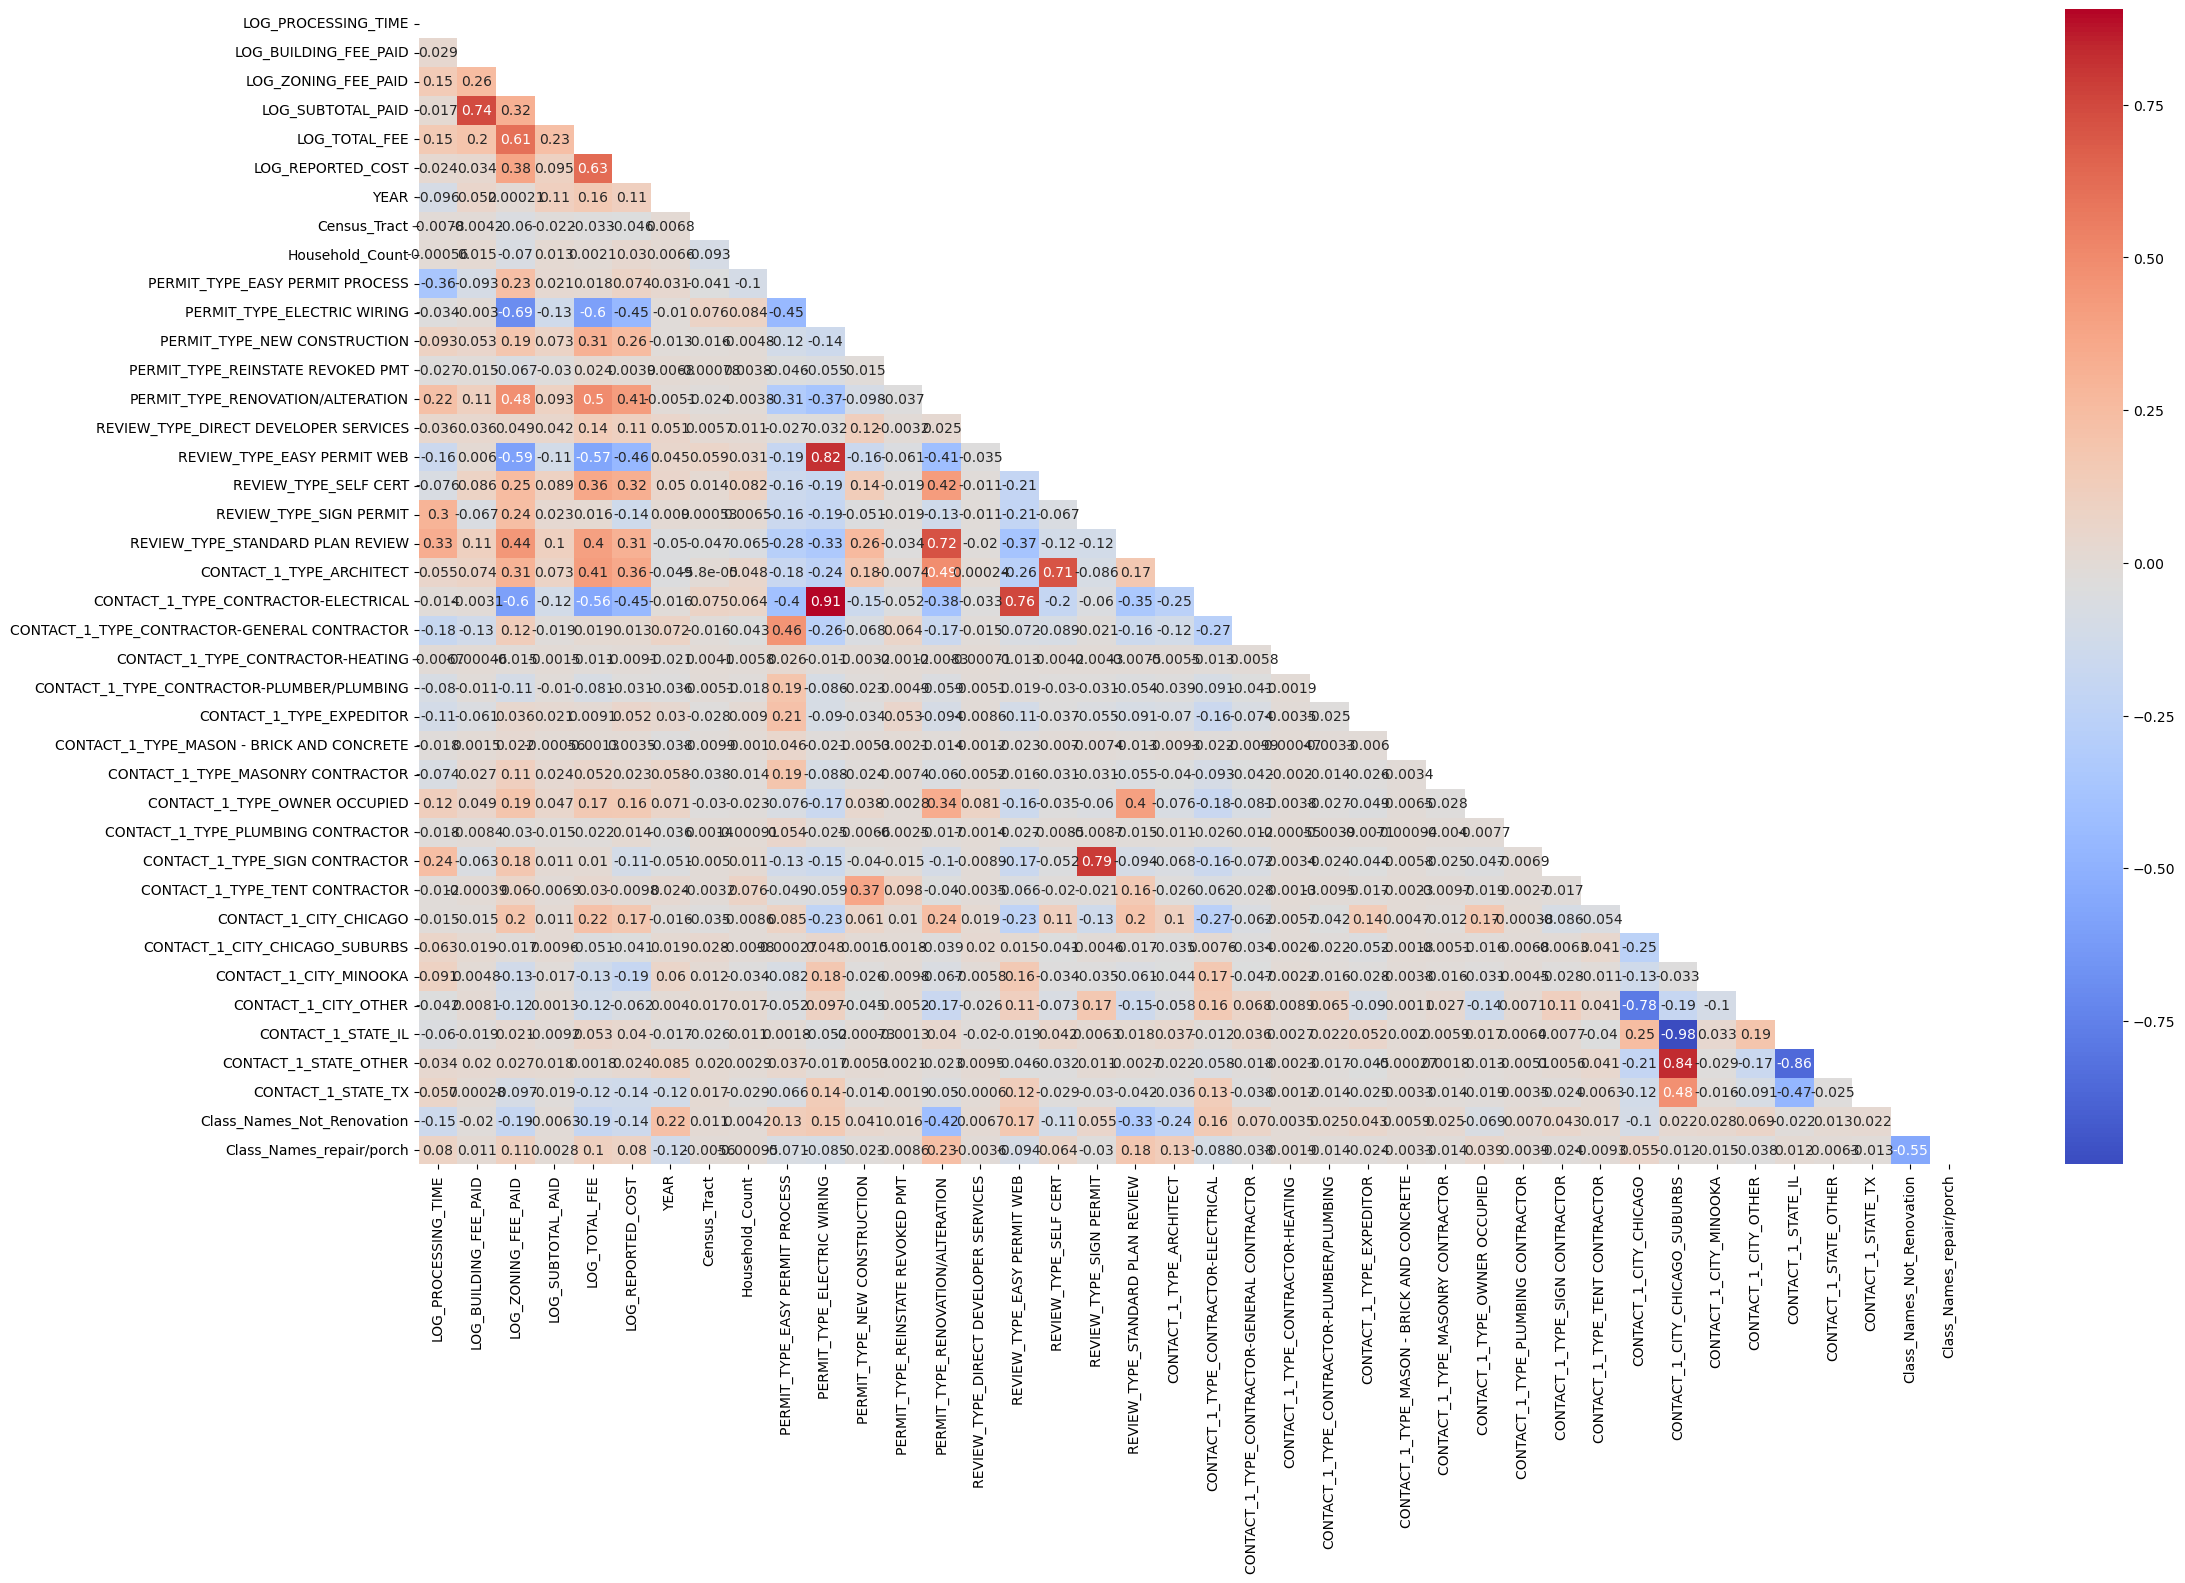

In [53]:

plt.figure(figsize=(25, 15))
matrix2 = np.triu(ind_corr)
sns.heatmap(ind_corr, annot=True, mask=matrix2, cmap='coolwarm')
plt.show()

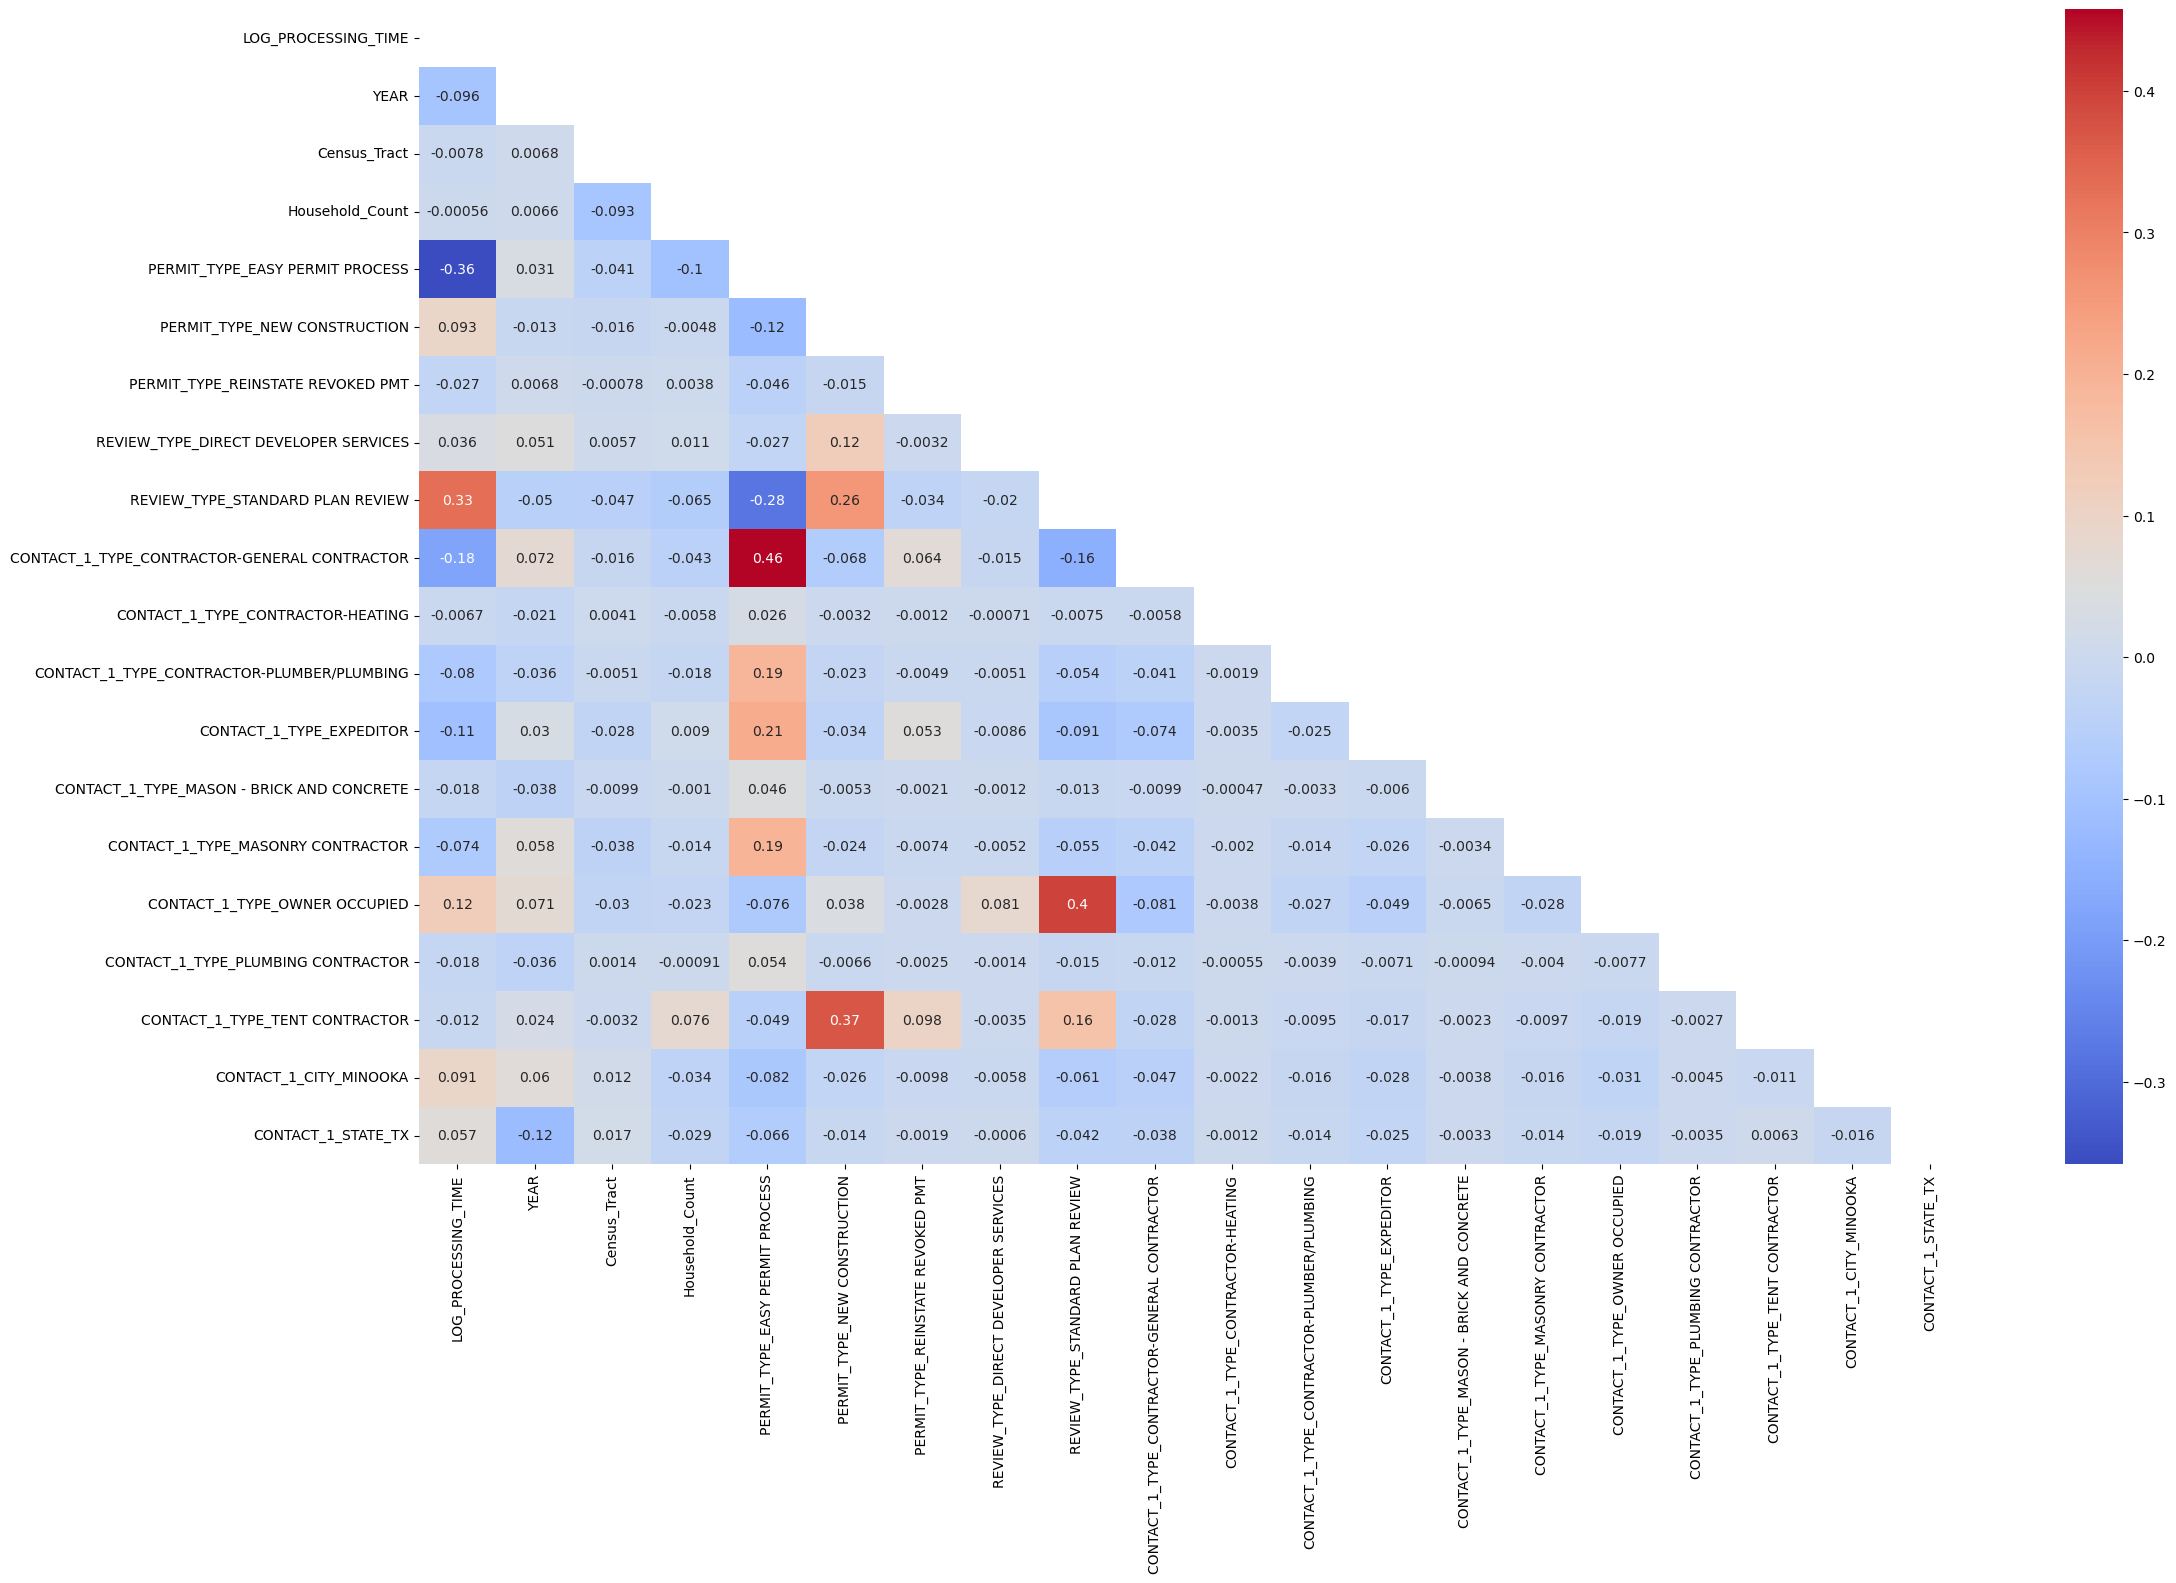

In [54]:
ind_corr=df_temp.drop(columns=multi_col_drop).corr()
plt.figure(figsize=(25, 15))
matrix2 = np.triu(ind_corr)
sns.heatmap(ind_corr, annot=True, mask=matrix2, cmap='coolwarm')
plt.show()

In [55]:
df_temp=df_temp.drop(columns=multi_col_drop)

In [56]:
df_temp

,LOG_PROCESSING_TIME,YEAR,Census_Tract,Household_Count,PERMIT_TYPE_EASY PERMIT PROCESS,PERMIT_TYPE_NEW CONSTRUCTION,PERMIT_TYPE_REINSTATE REVOKED PMT,REVIEW_TYPE_DIRECT DEVELOPER SERVICES,REVIEW_TYPE_STANDARD PLAN REVIEW,CONTACT_1_TYPE_CONTRACTOR-GENERAL CONTRACTOR,CONTACT_1_TYPE_CONTRACTOR-HEATING,CONTACT_1_TYPE_CONTRACTOR-PLUMBER/PLUMBING,CONTACT_1_TYPE_EXPEDITOR,CONTACT_1_TYPE_MASON - BRICK AND CONCRETE,CONTACT_1_TYPE_MASONRY CONTRACTOR,CONTACT_1_TYPE_OWNER OCCUPIED,CONTACT_1_TYPE_PLUMBING CONTRACTOR,CONTACT_1_TYPE_TENT CONTRACTOR,CONTACT_1_CITY_MINOOKA,CONTACT_1_STATE_TX
0,4.394449,2006,220702.0,1320.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.583519,2006,220702.0,1320.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-23.025851,2006,220702.0,1320.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.197225,2006,220702.0,1320.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.564949,2006,220702.0,1320.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724864,-23.025851,2006,820901.0,1872.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
724865,3.433987,2007,821600.0,1632.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
724866,2.772589,2007,821600.0,1632.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
724867,1.791759,2007,812500.0,1561.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
#export the list columns with multicollinearity 
joblib.dump(multi_col_drop, '../data/interim/MODEL_milticol.pkl')

['../data/interim/MODEL_milticol.pkl']